In [1]:
%load_ext autoreload
%autoreload 2

In [289]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.metrics import roc_auc_score, roc_curve

## Load data

In [3]:
df_predictors = pd.read_pickle('../data/external/df_predictors.pkl')
s_dp = df_predictors.dp.asfreq('M')
s_ret = df_predictors['Index'].pct_change().asfreq('M')

In [4]:
div_yield = s_dp.diff()[s_dp.index.year >= 1980]
returns = s_ret[s_ret.index.year >= 1980]

In [5]:
series = returns

## Class HMM

In [325]:
class HMM:
    
    def __init__(self, emission_models=(), transition_matrix=None, start_probas=None):
        '''WIP, OK'''
        self.emission_models = emission_models
        self.transition_matrix = transition_matrix
        self.start_probas = start_probas
        
        self.k = None
        
    def _check(self):
        '''WIP'''
        assert len(self.emissions) == self.transistion_matrix.shape[0] == self.transistion_matrix.shape[0] == len(self.start_probas), 'ERROR'
    
    @property
    def steady_state(self):
        '''FIX'''
        k = self.transition_matrix.shape[0]
        steady_state = np.full(k, 1/k).reshape(1, -1) @ self.transition_matrix
        return steady_state
        
    def _initialise_baum_welch(self, Y):
        '''FIX'''
        if self.start_probas is None:
            self.start_probas = self.steady_state
        
        A = np.array(self.transition_matrix)
        models = self.emission_models
        pi = np.array(self.start_probas).reshape(1, -1)
        return A, pi, models
    
    def _evaluate_emission_models(self, Y, emission_models):
        '''OK'''
        B = np.concatenate([model.pdf(Y).reshape(-1, 1) for model in emission_models], axis=1)
        return B
        
    def _forward_pass(self, A, B, pi):
        '''OK'''
        # initialise forward pass with first observation
        alpha_0 = pi * B[0]
        c_0 = 1/alpha_0.sum()
        
        # save values & scaling factor
        Alpha = alpha_0*c_0
        C = [c_0]
        
        # iterate
        for b_t in B[1:]:
            # calculate
            alpha_t = (b_t * Alpha[-1] @ A).reshape(1, -1)
            c_t = 1/alpha_t.sum()
            
            # save
            Alpha = np.concatenate((Alpha, alpha_t*c_t), axis=0)
            C += [c_t]
            
        C = np.array(C).reshape(-1, 1)
        return Alpha, C
            
    def _backward_pass(self, A, B, pi, C):
        '''OK'''
        # initialise backward pass as one
        beta_T = np.ones(pi.shape)
        
        # save values & scaling factor
        Beta = beta_T*C[-1]
        
        # iterate
        for b_t, c_t in zip(B[:0:-1],C[len(C)-2::-1]):
            # calculate
            beta_t = (b_t * Beta[0] @ A.T).reshape(1, -1)
            
            # save
            Beta = np.concatenate((beta_t*c_t, Beta), axis=0)
            
        return Beta
    
    def _emission_odds(self, Alpha, Beta):
        '''OK'''
        total = Alpha * Beta
        Gamma = total/total.sum(axis=1).reshape(-1, 1)
        return Gamma
    
    def _transition_odds(self, A, B, Alpha, Beta):
        '''OK'''
        Alpha_block = np.kron(Alpha[:-1], np.ones(A.shape[0]))
        B_Beta_block = np.kron(np.ones(A.shape[0]), B[1:]*Beta[1:])
        total = Alpha_block * B_Beta_block * A.reshape(1, -1)
        Xi = total/total.sum(axis=1).reshape(-1, 1)
        return Xi
        
    def _do_e_step(self, Y, A, B, pi):
        '''OK'''
        Alpha, C = self._forward_pass(A, B, pi)
        Beta = self._backward_pass(A, B, pi, C)
        Gamma = self._emission_odds(Alpha, Beta)
        Xi = self._transition_odds(A, B, Alpha, Beta)
        return Alpha, Gamma, Xi
    
    def _update_transition_matrix(self, Gamma, Xi):
        '''OK'''
        numerator = Xi.sum(axis=0)
        denominator = np.kron(Gamma[:-1], np.ones(Gamma.shape[1])).sum(axis=0)
        A_ = (numerator/denominator).reshape(Gamma.shape[1], Gamma.shape[1])
        return A_
    
    def _update_parameters(self, Y, emission_models, Gamma):
        '''OK'''
        models_ = []
        for model, weights in zip(emission_models, Gamma.T):
            model.fit(Y, weights)
            models_ += [model]
        return tuple(models_)
    
    def _update_initial_state(self, Gamma):
        '''OK'''
        return Gamma[0].reshape(1, -1)
    
    def _do_m_step(self, Y, models, Gamma, Xi):
        '''OK'''
        A_ = self._update_transition_matrix(Gamma, Xi)
        models_ = self._update_parameters(Y, models, Gamma)
        pi_ = self._update_initial_state(Gamma)
        return A_, models_, pi_
    
    def _score(self, Y, emission_models, Gamma):
        '''OK'''
        B = self._evaluate_emission_models(Y, emission_models)
        score = (B * Gamma).sum()    
        return score, B
    
    def _update_attributes(self, A_, models_, pi_, Gamma, Alpha):
        '''OK'''
        self.transition_matrix = A_
        self.emission_models = models_
        self.start_probas = pi_
        self.smoothened_probabilities = Gamma
        self.filtered_probabilities = Alpha
    
    def _estimate_baum_welch(self, Y, max_iter=100, threshold=1e-6):
        '''WIP'''
        
        #self._check()
        
        A_, pi_, models_ = self._initialise_baum_welch(Y)
        iteration = 0
        score_, B_ = self._score(Y, models_, pi_)
        scores = {iteration: score_}
        while iteration < max_iter:
            iteration += 1
            Alpha, Gamma, Xi = self._do_e_step(Y, A_, B_, pi_)
            A_, models_, pi_ = self._do_m_step(Y, models_, Gamma, Xi) ##update B, transition matrix wrong for k>2
            score_, B_ = self._score(Y, models_, pi_)
            scores[iteration] = score_
            
            if abs(scores[iteration]-scores[iteration-1]) < threshold:
                break
                
            if iteration == max_iter:
                warnings.warn('maximum number of iterations reached')
        else:
            warnings.warn('maximum number of iterations reached')
                
        self._update_attributes(A_, models_, pi_, Gamma, Alpha)
        
        return self, scores
            
    def fit(self, Y, method='baumwelch', **kwargs):
        '''FIX'''
        if method == 'baumwelch':
            self = self._estimate_baum_welch(self, Y, **kwargs)
        return self

In [315]:
class NormalModel:
    def __init__(self, mu=0, sigma2=1):
        self.mu = mu
        self.sigma2 = sigma2
        
    def fit(self, Y, weights=None):
        '''fits the model parameters to an observation sequence, weights are optional'''
        # prepare
        Y = np.array(Y).reshape(-1, 1)
        if weights is None:
            weights = np.ones(Y.shape)
        else:
            weights = np.array(weights).reshape(-1, 1)
        
        # estimate mean
        mean = (Y*weights).sum(axis=0)/weights.sum(axis=0)
        
        # estimate variance
        errors = (Y-mean)**2
        variance = (errors*weights).sum(axis=0)/weights.sum(axis=0)
        
        # update
        self.mu = mean
        self.sigma2 = variance
        
    def pdf(self, Y):
        '''returns the likelihood of each observation in an observation sequence'''
        pdf = 1/(self.sigma2**0.5 * np.sqrt(2*np.pi)) * np.exp(-0.5*(Y-self.mu)**2/self.sigma2)
        return pdf
    
    def score(self, Y):
        '''returns the likelihood of an observation sequence'''
        score = self.pdf(Y).prod()
        return score

## Generate Data

In [327]:
Y = np.concatenate((np.random.randn(100),np.random.randn(100)*2+2,np.random.randn(100)*2-2))

In [317]:
Y = np.array([])
for i in range(10):
    Y = np.concatenate((Y,np.random.randn(10)*2+2))
    Y = np.concatenate((Y,np.random.randn(10)))

In [318]:
Y = np.array([])
for i in range(10):
    Y = np.concatenate((Y,np.random.randn(10)*2+2))
    Y = np.concatenate((Y,np.random.randn(10)))
    Y = np.concatenate((Y,np.random.randn(10)*2-2))

## Three-State Model

In [328]:
test = HMM()
test.start_probas = np.array([[0.3, 0.4, 0.3]])
test.transition_matrix = np.array([[0.3, 0.4, 0.3],[0.3, 0.4, 0.3],[0.3, 0.4, 0.3]])
test.emission_models = (NormalModel(mu=0, sigma2=1), NormalModel(mu=1, sigma2=1),NormalModel(mu=-1, sigma2=1))

#A,B,pi,models = test._initialise_baum_welch(Y)

#print(test._score(Y, models, Gamma))

# Alpha_0, C = test._forward_pass(A,B,pi)
# Beta_0 = test._backward_pass(A,B,pi,C)
# Gamma_0 = test._emission_odds(Alpha_0, Beta_0)
# Xi_0 = test._transition_odds(A, B, Alpha_0, Beta_0)

#Gamma, Xi = test._do_e_step(Y, A, B, pi)

#pi_0 = test._update_initial_state(Gamma)
#A_0 = test._update_transition_matrix(Gamma, Xi)
#models_0 = test._update_parameters(Y, models, Gamma)

#A_, models_, pi_ = test._do_m_step(Y, models, Gamma, Xi)

#score = test._score(Y, models_, Gamma)
test._estimate_baum_welch(Y, max_iter=1000)

/home/rubelrennfix/.virtualenvs/hmmdalah/lib/python3.6/site-packages/ipykernel_launcher.py:160: UserWarning: maximum number of iterations reached
/home/rubelrennfix/.virtualenvs/hmmdalah/lib/python3.6/site-packages/ipykernel_launcher.py:162: UserWarning: maximum number of iterations reached


(<__main__.HMM at 0x7f1481dc3208>,
 {0: 47.55389206357759,
  1: 36.493732688197134,
  2: 36.494977259836084,
  3: 36.49499136297289,
  4: 36.49500522552618,
  5: 36.49501910072303,
  6: 36.4950329886331,
  7: 36.49504688933775,
  8: 36.495060802918665,
  9: 36.495074729457784,
  10: 36.49508866903737,
  11: 36.49510262174,
  12: 36.49511658764853,
  13: 36.49513056684614,
  14: 36.495144559416296,
  15: 36.49515856544278,
  16: 36.49517258500964,
  17: 36.49518661820126,
  18: 36.4952006651023,
  19: 36.49521472579771,
  20: 36.49522880037273,
  21: 36.4952428889129,
  22: 36.49525699150404,
  23: 36.495271108232295,
  24: 36.49528523918406,
  25: 36.49529938444601,
  26: 36.495313544105116,
  27: 36.495327718248646,
  28: 36.49534190696415,
  29: 36.49535611033944,
  30: 36.495370328462606,
  31: 36.495384561422014,
  32: 36.49539880930634,
  33: 36.49541307220447,
  34: 36.49542735020563,
  35: 36.495441643399275,
  36: 36.49545595187515,
  37: 36.49547027572324,
  38: 36.49548461503

In [320]:
test.transition_matrix.round(2)

array([[0.23, 0.39, 0.38],
       [0.23, 0.39, 0.38],
       [0.23, 0.4 , 0.37]])

In [321]:
[(m.mu,m.sigma2) for m in test.emission_models]

[(array([-0.09062603]), array([5.75157946])),
 (array([-0.09046217]), array([5.75158062])),
 (array([-0.11010454]), array([5.74535373]))]

<AxesSubplot:>

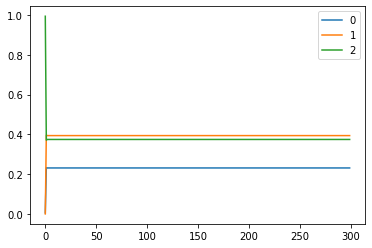

In [322]:
F = pd.DataFrame(test.filtered_probabilities)
F.plot()

<AxesSubplot:>

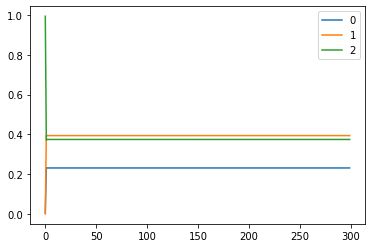

In [323]:
S = pd.DataFrame(test.smoothened_probabilities)
S.plot()

## Two-State Model

In [305]:
test = HMM()
test.start_probas = np.array([[0.3, 0.7]])
test.transition_matrix = np.array([[0.5, 0.5],[0.2, 0.8]])
test.emission_models = (NormalModel(mu=0, sigma2=1), NormalModel(mu=1, sigma2=1))

#A,B,pi,models = test._initialise_baum_welch(Y)

#print(test._score(Y, models, Gamma))

# Alpha_0, C = test._forward_pass(A,B,pi)
# Beta_0 = test._backward_pass(A,B,pi,C)
# Gamma_0 = test._emission_odds(Alpha_0, Beta_0)
# Xi_0 = test._transition_odds(A, B, Alpha_0, Beta_0)

#Gamma, Xi = test._do_e_step(Y, A, B, pi)

#pi_0 = test._update_initial_state(Gamma)
#A_0 = test._update_transition_matrix(Gamma, Xi)
#models_0 = test._update_parameters(Y, models, Gamma)

#A_, models_, pi_ = test._do_m_step(Y, models, Gamma, Xi)

#score = test._score(Y, models_, Gamma)
test._estimate_baum_welch(Y, max_iter=1000)

(<__main__.HMM at 0x7f14819a3c88>,
 {0: 48.15337802748243,
  1: 37.280646000650826,
  2: 37.06123948624291,
  3: 37.08326194826375,
  4: 37.103841728115704,
  5: 37.12945046628834,
  6: 37.15492317771239,
  7: 37.177778451436225,
  8: 37.1970400585233,
  9: 37.212593206059964,
  10: 37.22475891880201,
  11: 37.23403458122247,
  12: 37.24094911201907,
  13: 37.24599088537363,
  14: 37.249578430357644,
  15: 37.25205436521121,
  16: 37.253690703177746,
  17: 37.254698772187055,
  18: 37.255240155259145,
  19: 37.2554369147872,
  20: 37.255380397625686,
  21: 37.25513845979007,
  22: 37.254761209472406,
  23: 37.254285472194184,
  24: 37.25373820659139,
  25: 37.253139085574425,
  26: 37.2525024282948,
  27: 37.25183863531484,
  28: 37.251155248262606,
  29: 37.25045772835244,
  30: 37.249750026024664,
  31: 37.249034996336,
  32: 37.24831470101215,
  33: 37.24759062756599,
  34: 37.24686384793682,
  35: 37.24613513315242,
  36: 37.24540503608971,
  37: 37.24467395114146,
  38: 37.2439421

In [306]:
test.transition_matrix.round(2)

array([[0.93, 0.07],
       [0.08, 0.92]])

In [307]:
[(m.mu,m.sigma2) for m in test.emission_models]

[(array([-1.11178894]), array([4.03667701])),
 (array([1.02789437]), array([4.42043254]))]

<AxesSubplot:>

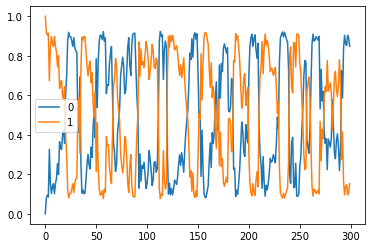

In [308]:
F = pd.DataFrame(test.filtered_probabilities)
F.plot()

<AxesSubplot:>

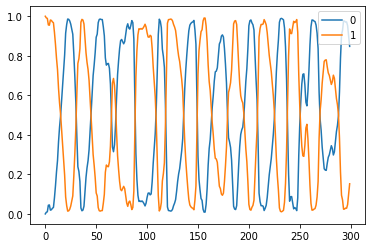

In [309]:
S = pd.DataFrame(test.smoothened_probabilities)
S.plot()

In [249]:
A_

NameError: name 'A_' is not defined

In [ ]:
np.kron(np.ones(2), Alpha_0)

In [ ]:
np.kron(Alpha_0, np.ones(2))

In [ ]:
Gamma

In [ ]:
Y = np.array(Y).reshape(-1, 1)
weighted_Y = Y * Gamma
means = weighted_Y.sum(axis=0)/Gamma.sum(axis=0)
Y

In [ ]:
means

In [ ]:
np.kron(np.ones(Gamma.shape[1]),Y)-means

In [ ]:
Gamma

In [ ]:
np.kron(Gamma, np.ones((1,2)))